In [1]:
from main import *
%matplotlib widget


def get_current_directory():
    try:
        
        directory = os.path.dirname(os.path.abspath(__file__))

    except:
        
        ip = IPython.get_ipython()
        directory = None
        if '__vsc_ipynb_file__' in ip.user_ns:
            directory = os.path.dirname(ip.user_ns['__vsc_ipynb_file__'])
        
    return directory 


def salvar(a):
    
    script_dir = get_current_directory()
    
    dados_dir = os.path.join(script_dir, 'dados')
    
    os.makedirs(dados_dir, exist_ok=True)
    
    file_path = os.path.join(dados_dir, f'{a}.pickle')
    
    with open(file_path, 'wb') as f:
        pickle.dump(eval(a), f)

def abrir(a):
    
    script_dir = get_current_directory()
    
    file_path = os.path.join(script_dir, 'dados', f'{a}.pickle')
    
    with open(file_path, 'rb') as f:
        return pickle.load(f)
    
def salvar_obj(obj, filename):
    script_dir = get_current_directory()
    dados_dir = os.path.join(script_dir, 'dados')
    os.makedirs(dados_dir, exist_ok=True)
    
    file_path = os.path.join(dados_dir, f'{filename}.pickle')
    
    with open(file_path, 'wb') as f:
        pickle.dump(obj, f)

In [4]:
hamiltoniano = es_problem.second_q_ops()[0]

mapper.map(hamiltoniano)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'ZIII', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.8567854 +0.j,  0.13716573+0.j, -0.13036292+0.j,  0.10622904+0.j,
  0.13716573+0.j,  0.15660062+0.j, -0.13036292+0.j,  0.15542669+0.j,
  0.04919765+0.j,  0.04919765+0.j,  0.04919765+0.j,  0.04919765+0.j,
  0.15542669+0.j,  0.16326769+0.j,  0.10622904+0.j])

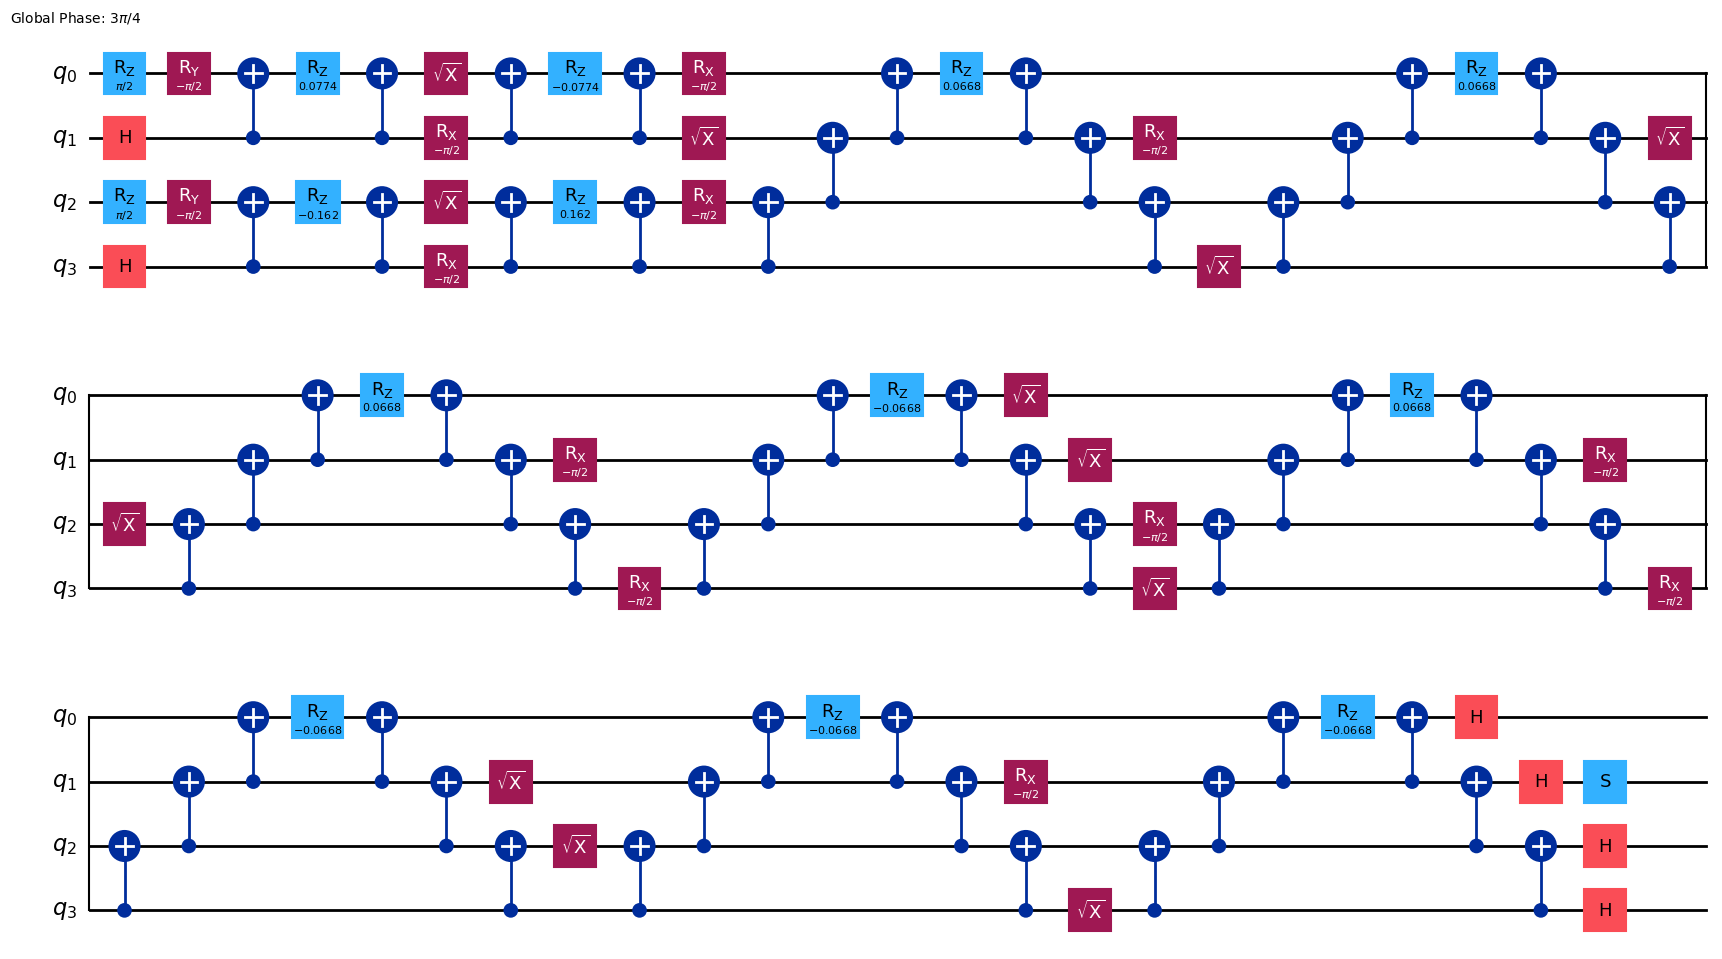

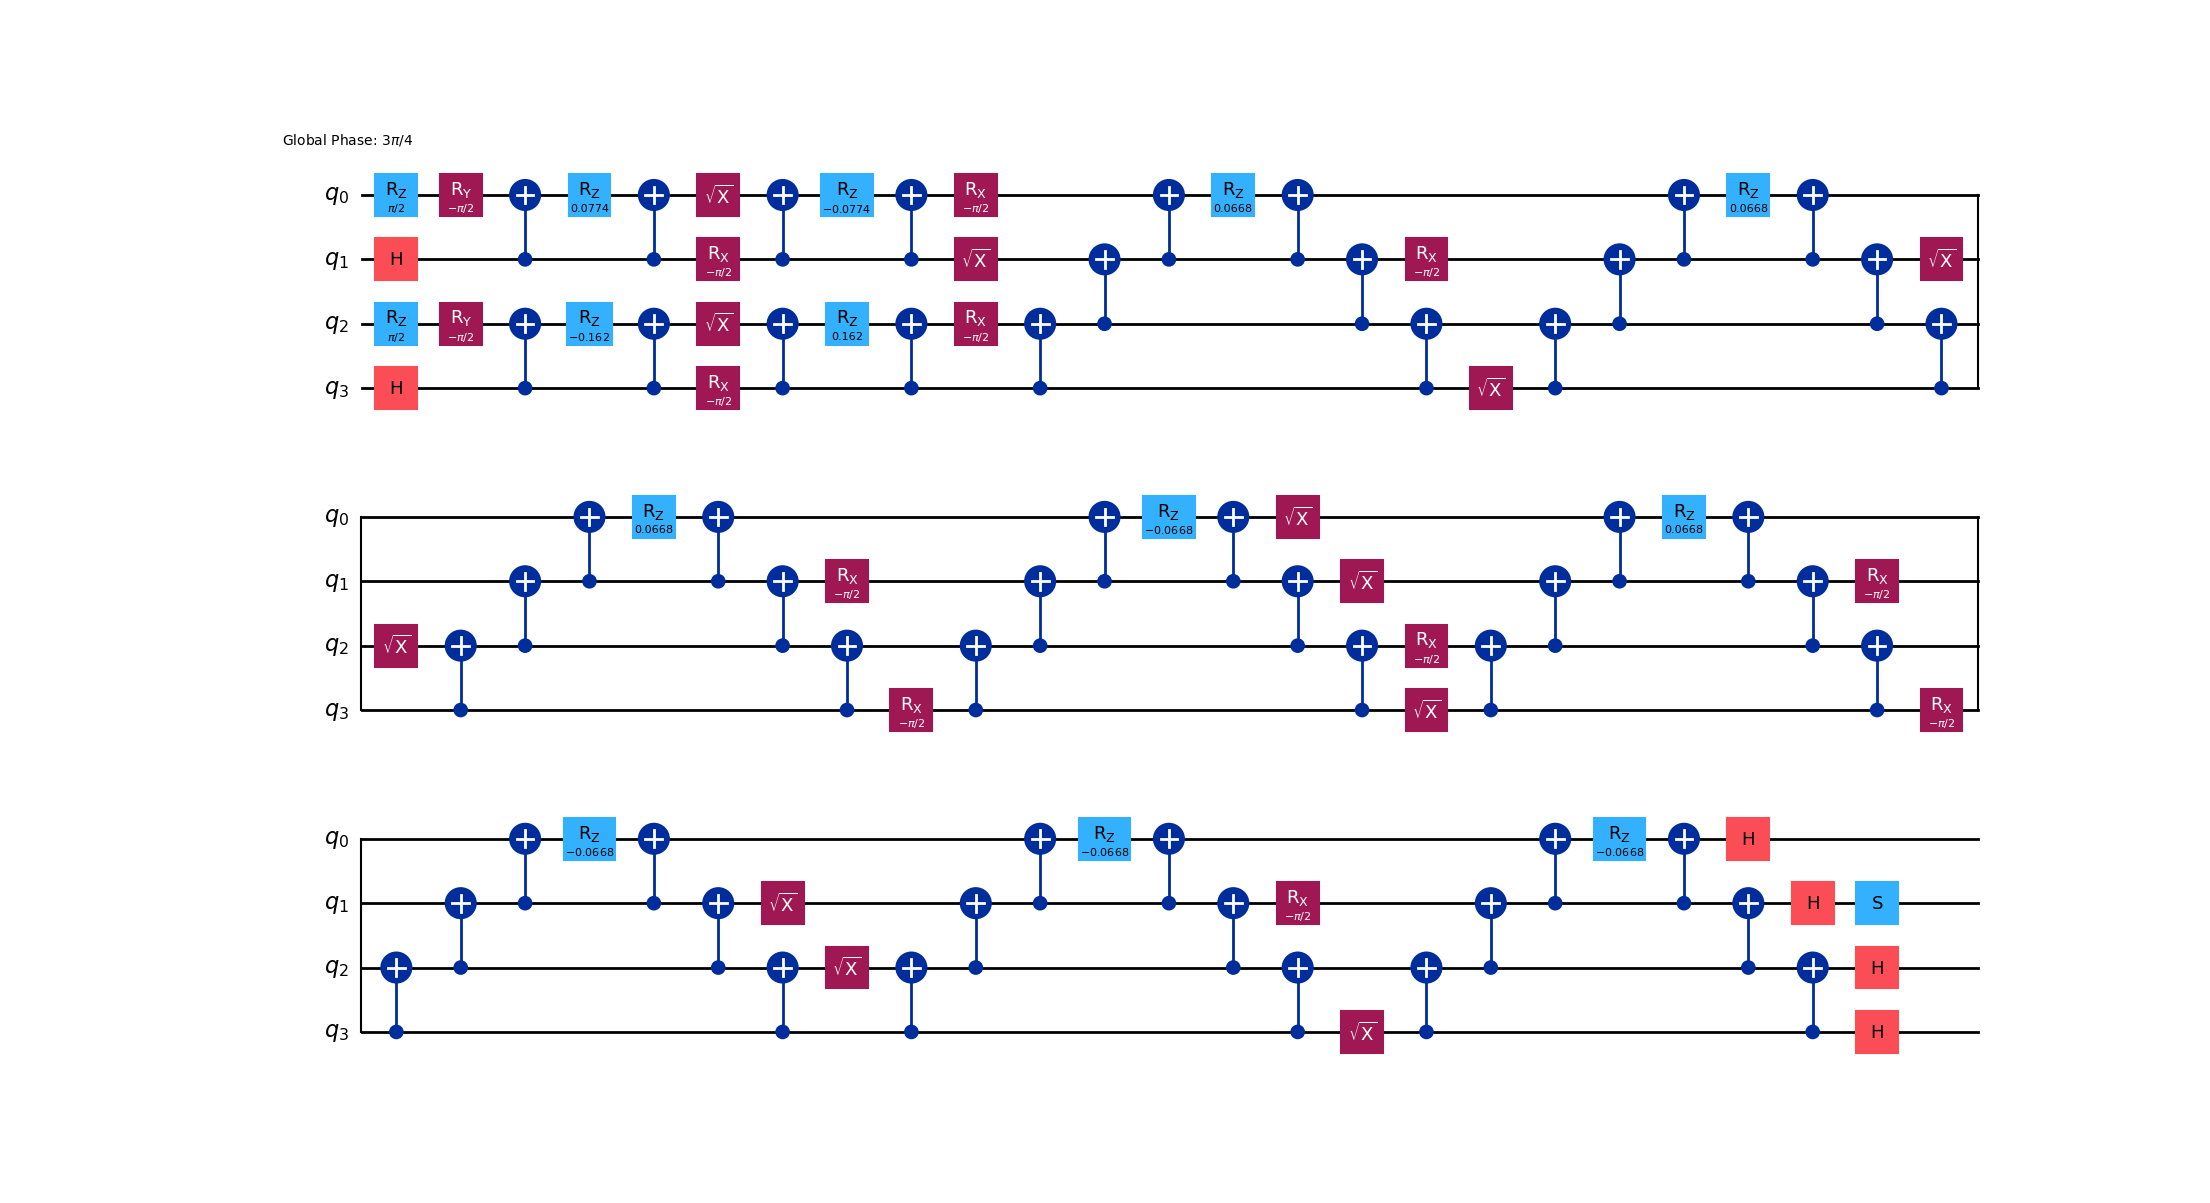

In [5]:
circuito_sv1 = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), sv1)

circuito_sv1.draw(output='mpl')

In [6]:
def run_estimator_aws(circuit, driver, backend, shots = 1000, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit
      
   #estimator = EstimatorV2(backend = backend, options = {"shots" : shots})
   estimator = EstimatorV2(backend = backend)
   estimator.options.default_shots = shots
   
   #job = estimator.run(circuit, mapper.map(hamiltoniano))
   job = estimator.run([(circuit, mapper.map(hamiltoniano), [])])
   
   return job



In [7]:
circuito_local = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), local_simulator)


j_local_simulator_Estimator_circuito = run_estimator_aws(circuito_local, es_problem, local_simulator, 2000)

/home/gabriel/miniconda/envs/aws_braket_updated_2/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:243: UserWarning: Options {'default_shots': 2000} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [8]:
j_sv1_Estimator_circuito = run_estimator_aws(circuito_sv1, es_problem, sv1, 2000)

TypeError: cannot pickle '_contextvars.Context' object

In [38]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp
import numpy as np

def valor_esperado(circuito, observable, backend, shots=1024):

    valor_esperado_0 = 0

    for pauli_, coeff in zip(observable.paulis, observable.coeffs):
        
        temp_circuito = circuito.copy()

        for qubit_index, pauli in enumerate(pauli_.to_label()):

            if pauli == 'X':

                temp_circuito.h(qubit_index)  

            elif pauli == 'Y':

                temp_circuito.sdg(qubit_index)
                temp_circuito.h(qubit_index)
        
        temp_circuito.measure_all()       
        
        job = backend.run(transpile(temp_circuito, backend), shots=shots)
        task_id = job.job_id()
        retrieved_job = backend.retrieve_job(task_id=task_id)
        counts = retrieved_job.result().get_counts()
        
        temp_expectation = 0
        total_counts = sum(counts.values())
        
        for resultado, count in counts.items():
        
            resultado = resultado[::-1]
        
            paridade = (-1) ** sum(int(resultado[qubit_index]) for qubit_index, pauli in enumerate(pauli_.to_label()) if pauli != 'I')
            temp_expectation += paridade * (count / total_counts)
        
        valor_esperado_0 += coeff.real * temp_expectation  
    
    return valor_esperado_0


In [39]:
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from qiskit_aer import Aer

qc = QuantumCircuit(1)
qc.h(0)  

observable = SparsePauliOp(['Z', 'X'], coeffs=[1.0, 0.5])

refined_value = valor_esperado(qc, observable, sv1, shots=1024)

estimator = Estimator()
estimator_value = estimator.run(circuits=[qc], observables=[observable]).result().values[0]

print(f"Refined Custom Estimator Value: {refined_value}")
print(f"EstimatorV2 Value: {estimator_value}")


Refined Custom Estimator Value: 0.47265625
EstimatorV2 Value: 0.4999999999999999


In [ ]:
expectation_value_sv1 = valor_esperado(circuito_sv1, mapper.map(es_problem.second_q_ops()[0]), sv1, shots=1024)

expectation_value_Aer_local = run_estimator_aer(circuito_sv1, es_problem)

print(f"Expectation value SV1: {expectation_value_sv1}\nExpectation value Aer local: {expectation_value_Aer_local}")

/home/gabriel/miniconda/envs/aws_braket_updated_2/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:500: UserWarning: Device does not support global phase; global phase of 2.356194490192345 will not be included in Braket circuit
  warnings.warn(
/home/gabriel/miniconda/envs/aws_braket_updated_2/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:500: UserWarning: Device does not support global phase; global phase of 0.7853981633974483 will not be included in Braket circuit
  warnings.warn(
/home/gabriel/miniconda/envs/aws_braket_updated_2/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:500: UserWarning: Device does not support global phase; global phase of 1.5707963267948966 will not be included in Braket circuit
  warnings.warn(


Expectation value SV1: -0.643863616612296
Expectation value Aer local: -1.6275059884201486


In [16]:
circuito_sv1.data

[CircuitInstruction(operation=Instruction(name='rz', num_qubits=1, num_clbits=0, params=[1.5707963267948966]), qubits=(Qubit(QuantumRegister(4, 'q'), 0),), clbits=()), CircuitInstruction(operation=Instruction(name='ry', num_qubits=1, num_clbits=0, params=[-1.5707963267948966]), qubits=(Qubit(QuantumRegister(4, 'q'), 0),), clbits=()), CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 1),), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 0)), clbits=()), CircuitInstruction(operation=Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.06701639381238685]), qubits=(Qubit(QuantumRegister(4, 'q'), 0),), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'),